In [88]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code."></form>''')

# Introducción

En presente trabajo se analizaron los resultados productivos de una empresa productora de pollos parrilleros para detectar las variables que impactan sobre los resultados y realizar recomendaciones a partir de ello. En segunda instancia se construyó un modelo de regresión 

## Obtención de base de datos

In [2]:
# Se presentan las librerías utilizadas:
import pandas as pd
import xlsxwriter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import numpy as np
import datetime
import statsmodels.api as sm
from scipy import stats
import requests
import json
import plotly.express as px
import ydata_profiling
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing


In [3]:
#Ingresos semanales compilado registra resultados finales de la producción en la pestaña BASE. Contiene además datos de genética, nutrición y sanidad.
df = pd.read_excel(r"C:\Users\ebover\OneDrive - FRIGORIFICO DE AVES SOYCHU S.A.I.C.F.I.A\ingresos semanales compilado.xlsx",sheet_name='BASE', skiprows=1 , usecols=range(1,67))

## Feature extraction preliminar

In [4]:
df.drop(df[(df['A.D.'] >100)].index, inplace=True) #Se eliminan valores erróneos
df.drop(df[(df['Edad'] >70)].index, inplace=True) #Se elimninan edades fuera de estándar
df.drop(df[(df['Destino'] =='EXP')].index, inplace=True) # se eliminan crianzas de pollos enviados a exportación


In [5]:
#subset para modelo
dfm=df[['granja','Cantid. BB','% a 7 Días','% Mortan.','A.D.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','Pes conv 2,7','zona prod' ]]
dfm.head()

,granja,Cantid. BB,% a 7 Días,% Mortan.,A.D.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,% desvío consumo std,zona climática,"Pes conv 2,7",zona prod
0,2544,36000,0.55,2.88,54.49,49.0,1,115.963592,verano,12.000000,S,N,San Pedro,-10.389276,Arrecifes,1.262878,BA
1,2558,57500,0.83,5.71,50.63,52.9,1,117.081839,verano,10.454545,N,N,Salto,-14.867094,Arrecifes,1.164476,BA
2,2761,39000,0.92,6.45,56.12,49.0,1,127.820226,verano,9.470000,N,N,Chivilcoy,-1.227077,25 de mayo,1.194771,BA
3,2524,30000,1.35,5.90,56.12,49.0,1,127.343729,verano,10.000000,N,N,San Pedro,-1.595289,Arrecifes,1.196094,BA
4,2741,42000,0.76,7.35,60.98,51.0,1,138.304026,verano,10.769231,N,N,Arrecifes,3.530095,Arrecifes,1.265246,BA


# Encoding

## Transformaciones categóricas

In [6]:
label_encoder = preprocessing.LabelEncoder()
dfm['Estación del año']= label_encoder.fit_transform(dfm['Estación del año'])
dfm['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfm['Ambiente controlado']= label_encoder.fit_transform(dfm['Ambiente controlado'])
dfm['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['localidad']= label_encoder.fit_transform(dfm['localidad'])
dfm['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['zona climática']= label_encoder.fit_transform(dfm['zona climática'])
dfm['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['zona prod']= label_encoder.fit_transform(dfm['zona prod'])
dfm['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['Ventilación forzada']= label_encoder.fit_transform(dfm['Ventilación forzada'])
dfm['Ventilación forzada'].unique()



C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\2426763063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['Estación del año']= label_encoder.fit_transform(dfm['Estación del año'])
C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\2426763063.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['Ambiente controlado']= label_encoder.fit_transform(dfm['Ambiente controlado'])
C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\2426763063.py:11: SettingWithCopyWarning: 
A value is trying to be set 

array([2, 1, 0])

# Feature selection

## Exploratory Data Analysis


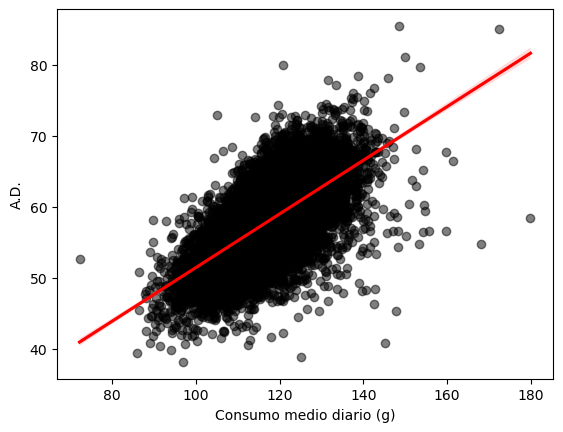

In [7]:
# Gráfico 1
sns.regplot(data=dfm, x = 'Consumo medio diario (g)', y = 'A.D.',
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99);

In [8]:
np.corrcoef(dfm['Consumo medio diario (g)'], dfm['A.D.'])

array([[1.       , 0.6435764],
       [0.6435764, 1.       ]])

Existe una mediana a alta correlación (64%) entre el consumo de alimento y la ganancia de peso, debido a ello se analizará la variable consumo como variable dependiente del modelo a aplicar.

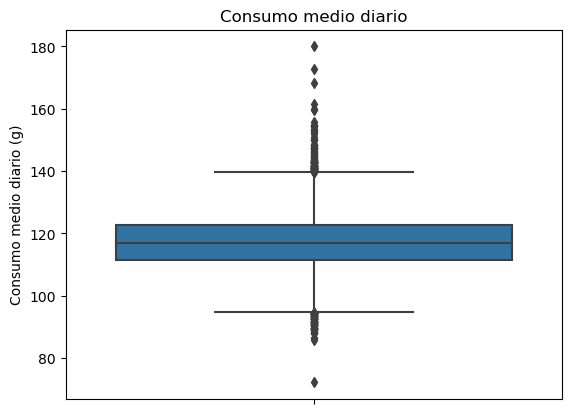

In [9]:
#Gráfico 2
ax=sns.boxplot(data=dfm, y='Consumo medio diario (g)') 
ax.set(title='Consumo medio diario');



Se observa una gran cantidad de valores outliers para la variable consumo por lo se generarán dos subsets para analizarlos por separado: 
dfmwo= Base de datos sin valores outliers
dfmout= Base de datos compuesta únicamente por valores outliers

In [10]:
dfmo=dfm

In [11]:
for x in ['Consumo medio diario (g)']:
    q75,q25 = np.percentile(dfmo.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    dfmo.loc[dfmo[x] < min,x] = np.nan
    dfmo.loc[dfmo[x] > max,x] = np.nan

In [12]:
dfmwo = dfmo.dropna(axis = 0)

In [13]:
for x in ['A.D.']:
    q75,q25 = np.percentile(dfmo.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    dfmo.loc[dfmo[x] < min,x] = np.nan
    dfmo.loc[dfmo[x] > max,x] = np.nan

In [14]:
dfmwo = dfmo.dropna(axis = 0)

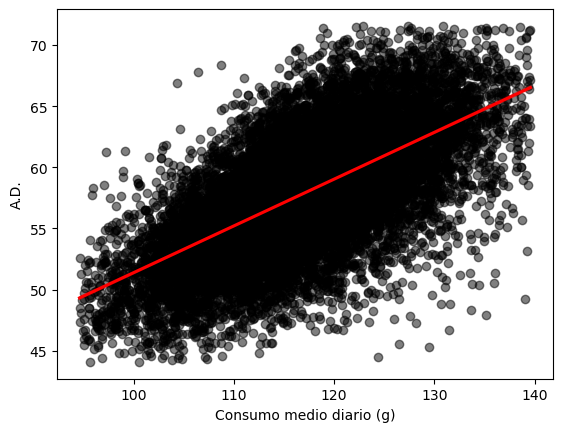

In [15]:
# Gráfico 4
sns.regplot(data=dfmwo, x = 'Consumo medio diario (g)', y = 'A.D.',
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99);

La correlación entre los valores de consumo y ganancia media diaria de peso no se modificó (63.7%) luego de la extracción de los valores outliers de la base de datos.

In [16]:
np.corrcoef(dfmwo['Consumo medio diario (g)'], dfmwo['A.D.'])

array([[1.        , 0.63779357],
       [0.63779357, 1.        ]])

In [63]:
# se crea un subset conformado por los valores outliers:
dfm2=df[['granja','Cantid. BB','% a 7 Días','% Mortan.','A.D.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','Pes conv 2,7','zona prod' ]]
dfm2.head()

,granja,Cantid. BB,% a 7 Días,% Mortan.,A.D.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,% desvío consumo std,zona climática,"Pes conv 2,7",zona prod
0,2544,36000,0.55,2.88,54.49,49.0,1,115.963592,verano,12.000000,S,N,San Pedro,-10.389276,Arrecifes,1.262878,BA
1,2558,57500,0.83,5.71,50.63,52.9,1,117.081839,verano,10.454545,N,N,Salto,-14.867094,Arrecifes,1.164476,BA
2,2761,39000,0.92,6.45,56.12,49.0,1,127.820226,verano,9.470000,N,N,Chivilcoy,-1.227077,25 de mayo,1.194771,BA
3,2524,30000,1.35,5.90,56.12,49.0,1,127.343729,verano,10.000000,N,N,San Pedro,-1.595289,Arrecifes,1.196094,BA
4,2741,42000,0.76,7.35,60.98,51.0,1,138.304026,verano,10.769231,N,N,Arrecifes,3.530095,Arrecifes,1.265246,BA


In [64]:
label_encoder = preprocessing.LabelEncoder()
dfm2['Estación del año']= label_encoder.fit_transform(dfm2['Estación del año'])
dfm2['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfm2['Ambiente controlado']= label_encoder.fit_transform(dfm2['Ambiente controlado'])
dfm2['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['localidad']= label_encoder.fit_transform(dfm2['localidad'])
dfm2['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['zona climática']= label_encoder.fit_transform(dfm2['zona climática'])
dfm2['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['zona prod']= label_encoder.fit_transform(dfm2['zona prod'])
dfm2['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['Ventilación forzada']= label_encoder.fit_transform(dfm2['Ventilación forzada'])
dfm2['Ventilación forzada'].unique()

C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\2352935430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2['Estación del año']= label_encoder.fit_transform(dfm2['Estación del año'])
C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\2352935430.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2['Ambiente controlado']= label_encoder.fit_transform(dfm2['Ambiente controlado'])
C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\2352935430.py:11: SettingWithCopyWarning: 
A value is trying to be 

array([2, 1, 0])

In [65]:
dfmout=dfm2

In [66]:
dfmout.drop(dfmout[(dfmout['A.D.'] >47.15) & (dfmout['A.D.'] <68.55)].index, inplace=True) 
dfmout.drop(dfmout[(dfmout['Consumo medio diario (g)'] >99.2) & (dfmout['Consumo medio diario (g)'] <196.05)].index, inplace=True)


C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\4169265845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmout.drop(dfmout[(dfmout['A.D.'] >47.15) & (dfmout['A.D.'] <68.55)].index, inplace=True)
C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\4169265845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmout.drop(dfmout[(dfmout['Consumo medio diario (g)'] >99.2) & (dfmout['Consumo medio diario (g)'] <196.05)].index, inplace=True)


In [67]:
dfmout.head()

,granja,Cantid. BB,% a 7 Días,% Mortan.,A.D.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,% desvío consumo std,zona climática,"Pes conv 2,7",zona prod
2349,2628,42000,2.20,12.25,46.57,49.2,3,94.951220,1,9.722222,1,0,5,-26.626561,1,1.240429,0
3080,2894,34000,3.66,15.32,42.72,45.4,5,97.854626,1,13.821138,1,0,5,-18.725394,1,1.061599,0
3161,2843,35000,1.94,16.07,43.80,50.0,6,98.112000,1,10.115607,1,0,37,-25.401460,1,1.120332,0
4597,2929,95000,2.88,13.30,47.09,48.4,8,97.983471,0,11.390887,1,0,7,-22.325242,1,1.216216,0
4807,2918,55500,1.59,24.52,46.58,47.2,12,93.686441,2,13.875000,1,0,31,-24.394528,0,1.240429,0


In [68]:
dfmout.tail()

,granja,Cantid. BB,% a 7 Días,% Mortan.,A.D.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,% desvío consumo std,zona climática,"Pes conv 2,7",zona prod
15558,1621,37000,1.77,20.55,43.90,51.9,3,97.526012,3,10.496454,1,0,21,-27.531400,2,1.144068,2
15576,1677,95300,2.47,34.94,41.85,52.8,3,97.943182,1,11.049275,1,0,10,-28.281450,2,1.078562,2
15599,710,16500,2.58,22.90,45.51,49.0,3,90.565306,1,11.000000,1,0,6,-29.425891,4,1.257764,2
15603,227,11000,1.46,20.45,44.31,51.0,4,88.627451,1,11.000000,1,0,26,-33.136095,4,1.257764,2
15642,39,50400,2.25,33.10,40.63,48.0,4,97.500000,1,10.475993,1,0,21,-22.708505,2,1.018868,2


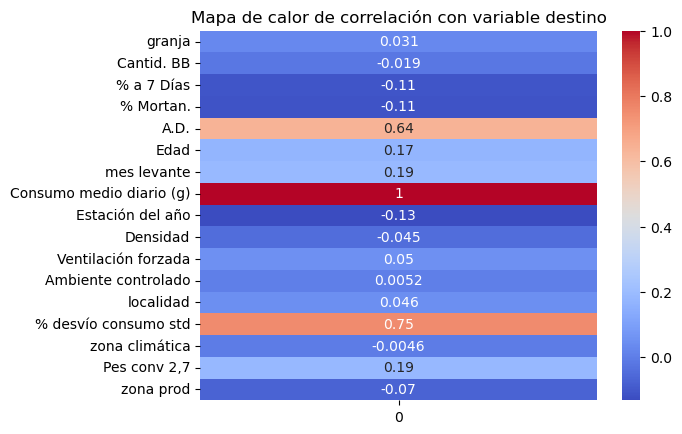

In [20]:
#Gráfico 5
corr = dfmwo.corr('pearson')
target_corr = corr['Consumo medio diario (g)'].values.reshape(-1,1)

sns.heatmap(target_corr, annot=True, yticklabels= dfmwo.columns, cmap='coolwarm')
plt.title('Mapa de calor de correlación con variable destino')
plt.show()


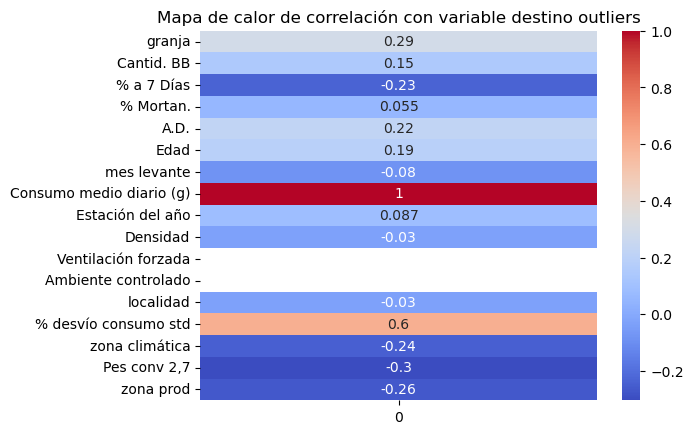

In [69]:
# Gráfico 6
corr = dfmout.corr('pearson')
target_corr = corr['Consumo medio diario (g)'].values.reshape(-1,1)

sns.heatmap(target_corr, annot=True, yticklabels= dfmout.columns, cmap='coolwarm')
plt.title('Mapa de calor de correlación con variable destino outliers')
plt.show()

Del análisis de los mapas de calor se desprende que las correlaciones entre el consumo y el resto de las variables analizadas son altas para la ganancia de peso y para el desvío del consumo de alimento respecto del estándar (dependiente). Para el caso del grupo de valores outliers ocurre lo mismo.

# Entrenamiento modelos machine learning

# RandomForestClassifier

Se confeccionó un modelo de clasificación para predecir la zona climática de producción en función de los valores del resto de las variables de la base.

In [22]:
# Seleccionar las variables predictoras y la variable de destino
X = dfmwo.drop('zona climática', 1) 
y = dfmwo['zona climática']

C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\1859563335.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = dfmwo.drop('zona climática', 1)


In [23]:
# Dividir el conjunto de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [25]:
# Obtener predicciones
y_pred= clf.predict(X_test)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       524
           1       0.88      0.99      0.93       999
           2       1.00      0.38      0.55      1025
           3       1.00      0.93      0.96        42
           4       0.73      1.00      0.84      1711

    accuracy                           0.82      4301
   macro avg       0.92      0.81      0.83      4301
weighted avg       0.86      0.82      0.79      4301



In [27]:
clf.feature_importances_

array([3.49585945e-01, 7.59913383e-02, 1.06582711e-02, 2.62322645e-03,
       3.72710344e-03, 1.83629909e-03, 2.03004968e-04, 1.17283062e-03,
       6.22708275e-05, 9.56958720e-03, 1.11041111e-02, 4.06240636e-03,
       1.58562087e-01, 8.73801343e-03, 1.53894801e-03, 3.60564557e-01])

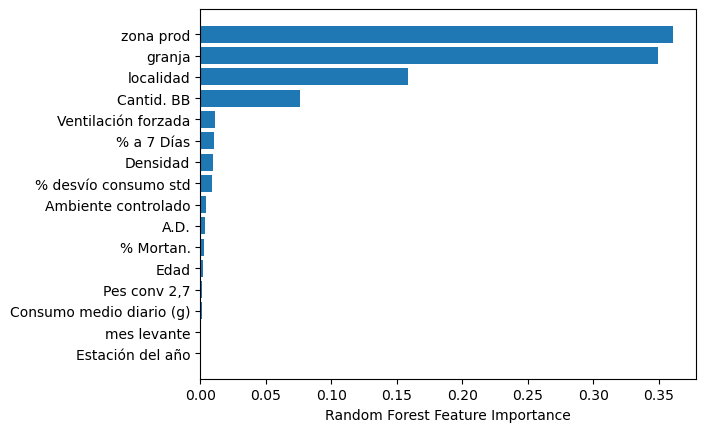

In [28]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

La precisión promedio alcanzada fue del 86%, lo que indica que el modelo fue capaz de clasificar correctamente la mayoría de las muestras. El modelo mostró una alta precisión para las clases 0, 1 y 3; mientras que la clase 2 tuvo una precisión perfecta, pero una baja recall y f1-score. Esto sugiere que el modelo tuvo dificultades para clasificar correctamente esta clase, ya que su recall fue del 40%.



## Base de datos sin outliers

# Linear regression

In [29]:
from sklearn.model_selection import train_test_split

X1=dfmwo.drop('Consumo medio diario (g)', 1) 

y1=dfmwo['Consumo medio diario (g)']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\846410607.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X1=dfmwo.drop('Consumo medio diario (g)', 1)


In [30]:
from sklearn.linear_model import LinearRegression


In [31]:
model = LinearRegression(fit_intercept=True)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)


In [32]:
print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

lr_test_mse = mean_squared_error(y1_test, y1_test_pred)
lr_train_mse = mean_squared_error(y1_train, y1_train_pred)

Error en datos de train: 0.4982651164623123
Error en datos de test: 0.5309155925056324


# KNN

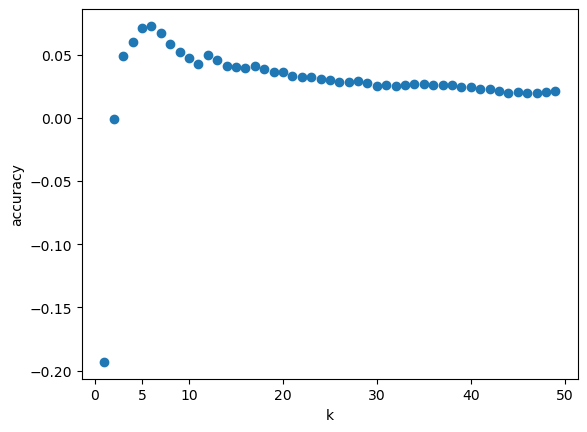

In [33]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X1_train, y1_train)
    scores.append(knn.score(X1_test, y1_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [34]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)



print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

knr_test_mse = mean_squared_error(y1_test, y1_test_pred)
knr_train_mse = mean_squared_error(y1_train, y1_train_pred)


Error en datos de train: 37.26719848751898
Error en datos de test: 37.20337553592021


# Random forest regression

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)

In [36]:
print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

rfr_test_mse = mean_squared_error(y1_train, y1_train_pred)
rfr_train_mse = mean_squared_error(y1_test, y1_test_pred)

Error en datos de train: 0.03285193175149815
Error en datos de test: 0.03204319352424198


# Xgboost

In [37]:
! pip install xgboost

In [38]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)

In [39]:
print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

xgb_test_mse = mean_squared_error(y1_train, y1_train_pred)
xgb_train_mse = mean_squared_error(y1_test, y1_test_pred)

Error en datos de train: 0.1416284786209982
Error en datos de test: 0.13511671157609048


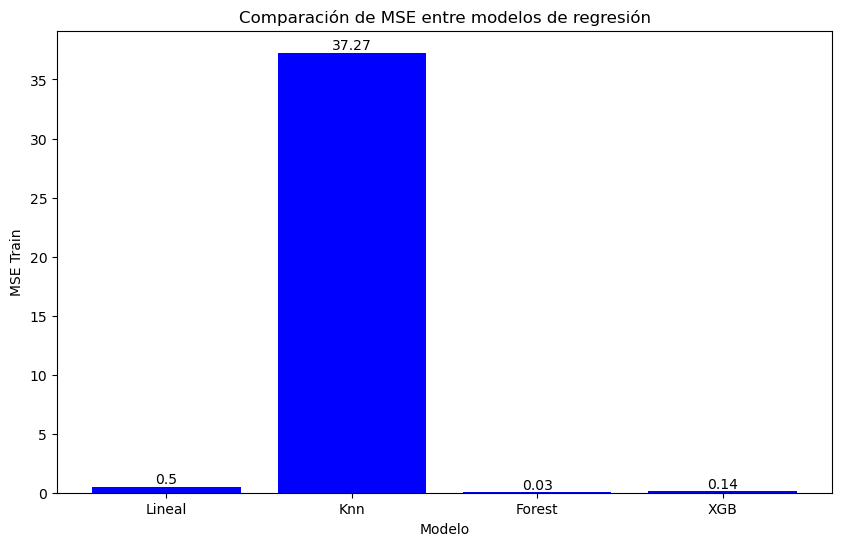

In [40]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

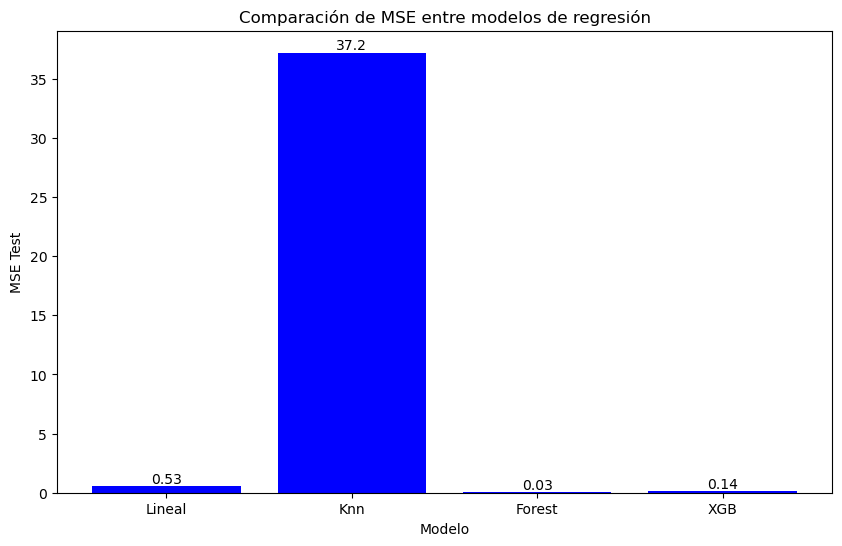

In [41]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y1_test, y1_test_pred)
print("MSE:", mse)

MSE: 0.13511671157609048


In [43]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.36758225144325246


In [44]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y1_test, y1_test_pred)
print("MAE:", mae)

MAE: 0.2864103313349916


In [45]:
from sklearn.metrics import r2_score
r2 = r2_score(y1_test, y1_test_pred)
print("R^2:", r2)

R^2: 0.9979802614206809


## Base solo outliers

## Linear regression

In [70]:
from sklearn.model_selection import train_test_split

X2=dfmout.drop('Consumo medio diario (g)', 1) 

y2=dfmout['Consumo medio diario (g)']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=42)

C:\Users\ebover\AppData\Local\Temp\ipykernel_26268\138716779.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2=dfmout.drop('Consumo medio diario (g)', 1)


In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
model = LinearRegression(fit_intercept=True)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [74]:
print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

lr_test_mse = mean_squared_error(y2_test, y2_test_pred)
lr_train_mse = mean_squared_error(y2_train, y2_train_pred)

Error en datos de train: 0.05875067281093576
Error en datos de test: 0.0344287903121363


# KNN

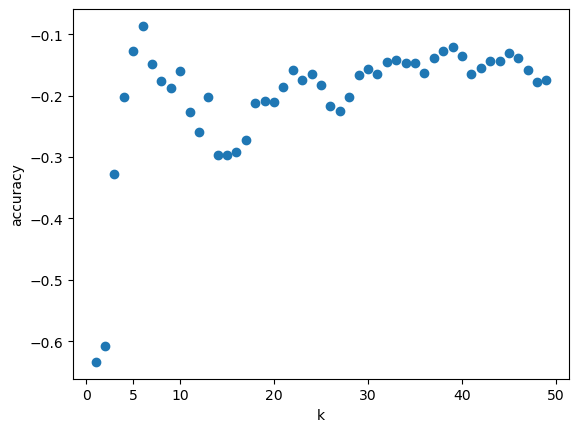

In [75]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X2_train, y2_train)
    scores.append(knn.score(X2_test, y2_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [76]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)



print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

knr_test_mse = mean_squared_error(y2_test, y2_test_pred)
knr_train_mse = mean_squared_error(y2_train, y2_train_pred)


Error en datos de train: 10.032969123294365
Error en datos de test: 6.468025277243761


## Random forest regression

In [77]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [78]:
print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

rfr_test_mse = mean_squared_error(y2_train, y2_train_pred)
rfr_train_mse = mean_squared_error(y2_test, y2_test_pred)

Error en datos de train: 0.5018280903923094
Error en datos de test: 0.3294320084761633


## Xgboost

In [79]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [80]:
print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

xgb_test_mse = mean_squared_error(y2_train, y2_train_pred)
xgb_train_mse = mean_squared_error(y2_test, y2_test_pred)

Error en datos de train: 3.848069932871696e-06
Error en datos de test: 1.1430481856880621e-06


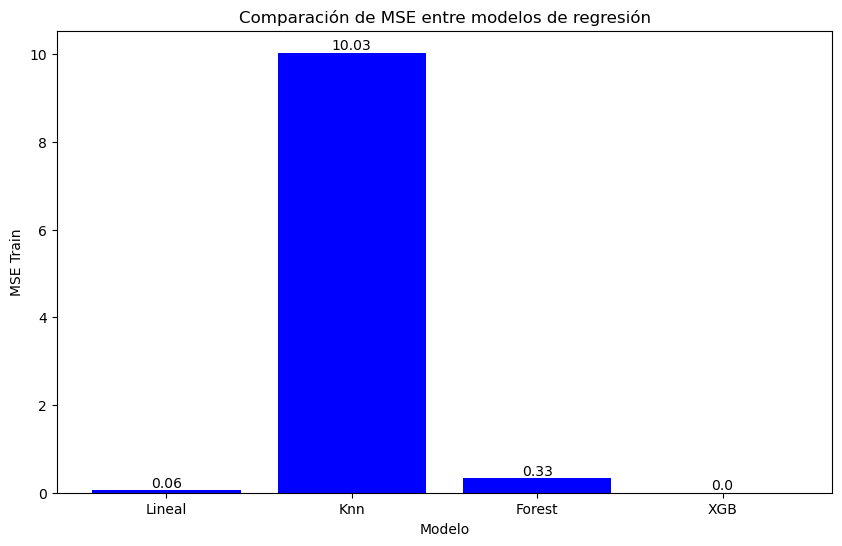

In [81]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

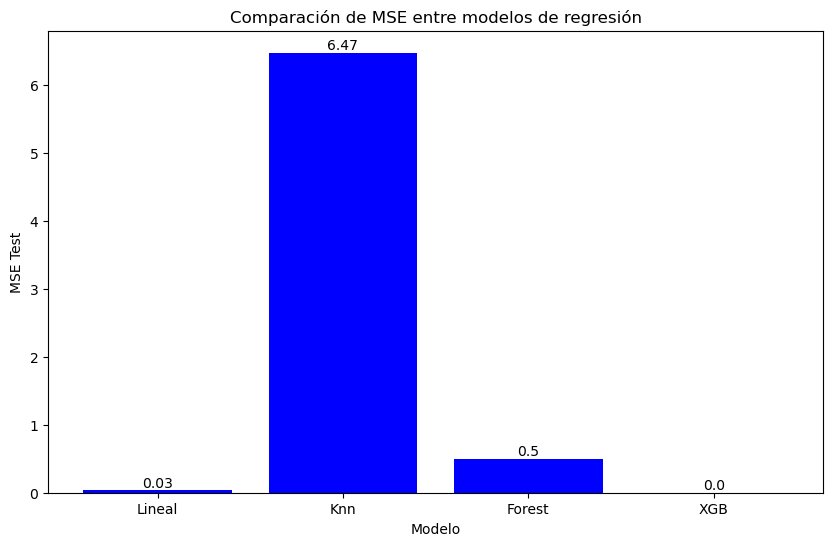

In [82]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [83]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y2_test, y2_test_pred)
print("MSE:", mse)

MSE: 1.1430481856880621e-06


In [84]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.0010691343160183673


In [85]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y2_test, y2_test_pred)
print("MAE:", mae)

MAE: 0.0008061070070484506


In [86]:
from sklearn.metrics import r2_score
r2 = r2_score(y2_test, y2_test_pred)
print("R^2:", r2)

R^2: 0.9999998404557338


Tanto en los modelos de la base de datos sin outliers y la de los outliers tienen buenos valores de MSE con excepción de KNN.